In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

data = pd.ExcelFile('PROPPR_longitudinal_data_dictionary_edm_5.13.20.xlsx')
df = pd.read_excel(data, 'PROPPR_longitudinal_dataset_edm')
df = df[df['TIMEPOINT'] == 0]
# selected_cols = list(df.iloc[:, 7:50])
selected_cols = list(df.iloc[:, 50:93])
data = df[selected_cols]
data = data.drop(['log2_Hu_IL_2__38', 'log2_Hu_IL_15__73', 'log2_Hu_IL_12_p70__75', 'log2_Hu_IL_17__76',
                 'log2_Hu_FGF_basic__44', 'log2_Hu_GM_CSF__34', 'log2_Hu_VEGF__45'], axis=1)
percent_missing = data.isna().sum() * 100 / len(data)
percent_missing

log2_Hu_IL_1b__39         14.814815
log2_Hu_IL_1ra__25        14.646465
log2_Hu_IL_4__52          14.309764
log2_Hu_IL_5__33          18.855219
log2_Hu_IL_6__19          13.131313
log2_Hu_IL_7__74          14.646465
log2_Hu_IL_8__54          14.309764
log2_Hu_IL_9__77          17.171717
log2_Hu_IL_10__56         13.973064
log2_Hu_IL_13__51         14.983165
log2_Hu_Eotaxin__43       13.468013
log2_Hu_G_CSF__57         15.488215
log2_Hu_IFN_g__21         17.340067
log2_Hu_IP_10__48         12.962963
log2_Hu_MCP_1_MCAF__53    13.299663
log2_Hu_MIP_1a__55        15.993266
log2_Hu_PDGF_bb__47       12.962963
log2_Hu_MIP_1b__18        13.131313
log2_Hu_RANTES__37        14.478114
log2_Hu_TNF_a__36         13.804714
log2_ang1                 14.309764
log2_ang2                 12.626263
log2_rage                 13.636364
log2_hmgb1                12.121212
log2_mbl                  17.003367
log2_pai1                 13.131313
log2_pap                  14.141414
log2_sdc1                 12

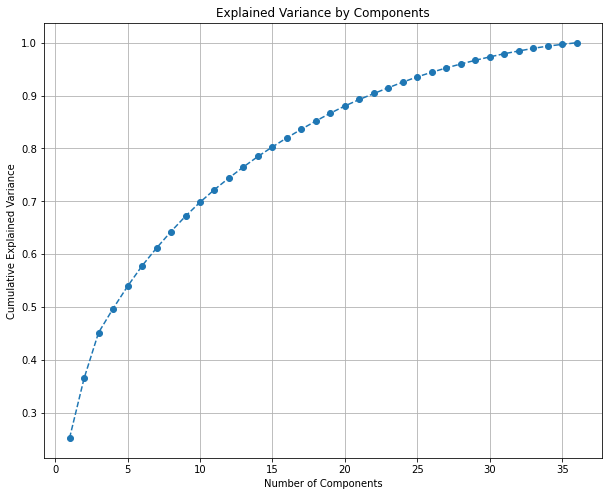

In [4]:
# Impute for missing data entries using mean.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(data)
data = imp.transform(data)
# data = data.fillna(0)
# print(data)

# Standardize data.
scalar = StandardScaler()
std = scalar.fit_transform(data)
pca = PCA()
pca.fit(std)

# Determine how many compnents.
plt.figure(figsize=(10, 8))
plt.plot(range(1, 37), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

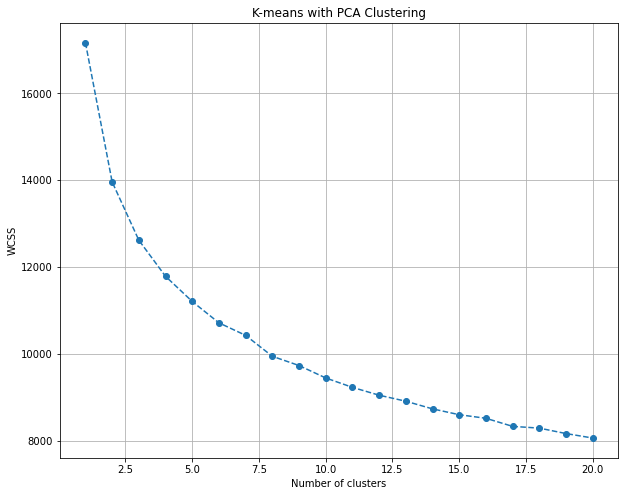

In [5]:
pca = PCA(n_components=15)
pca.fit(std)
scores_pca = pca.transform(std)

# Determine how many clusters.
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("K-means with PCA Clustering")
plt.grid()
plt.show()

In [160]:
range_clusters = range(2, 21)
for k in range_clusters:
    clusterer = KMeans(n_clusters=k)
    preds = clusterer.fit_predict(data)
    centers = clusterer.cluster_centers_
    score = silhouette_score(data, preds)
    print("For n_clusters = {}, silhouette score is {})".format(k, score))

For n_clusters = 2, silhouette score is 0.16904783421749198)
For n_clusters = 3, silhouette score is 0.14919120934090538)
For n_clusters = 4, silhouette score is 0.11983451143088568)
For n_clusters = 5, silhouette score is 0.08985974277736042)
For n_clusters = 6, silhouette score is 0.09314311206101138)
For n_clusters = 7, silhouette score is 0.09134234262387902)
For n_clusters = 8, silhouette score is 0.09136147221110905)
For n_clusters = 9, silhouette score is 0.09626313529590909)
For n_clusters = 10, silhouette score is 0.07826315499922776)
For n_clusters = 11, silhouette score is 0.09912005940349362)
For n_clusters = 12, silhouette score is 0.1035599843879742)
For n_clusters = 13, silhouette score is 0.09067417823891424)
For n_clusters = 14, silhouette score is 0.10322826792052636)
For n_clusters = 15, silhouette score is 0.0929369737726937)
For n_clusters = 16, silhouette score is 0.096940134279017)
For n_clusters = 17, silhouette score is 0.10032377490459941)
For n_clusters = 18,

In [6]:
# Do k-means
kmeans_pca = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans_pca.fit_predict(scores_pca)

score = silhouette_score(data, kmeans_pca.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score)

df_pca_kmeans = pd.concat([df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_pca_kmeans.columns.values[-15:] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5',
                                     'Component 6', 'Component 7', 'Component 8', 'Component 9', 'Component 10', 
                                     'Component 11', 'Component 12', 'Component 13', 'Component 14', 'Component 15']
df_pca_kmeans['K-means PCA'] = kmeans_pca.labels_

df_pca_kmeans['Clusters'] = df_pca_kmeans['K-means PCA'].map({0: 'first', 1: 'second'}) #, 2: 'third', 3: 'fourth',
                                                             # 4: 'fifth'})
df_pca_kmeans.head()

Silhouetter Score: 0.172


,biomarker_key_PROPPRID,biomarker_key_SUBJECTID,LABID,CLINICAL_STUDY_ID,biomarker_key_SITE_NUM,PLATENUM,TIMEPOINT,Hu_IL_1b__39,Hu_IL_1ra__25,Hu_IL_2__38,...,Component 8,Component 9,Component 10,Component 11,Component 12,Component 13,Component 14,Component 15,K-means PCA,Clusters
0,1010002,1212,1011000,1010002,5,40,0,2.20,140.35,NaN,...,-0.897732,-0.148290,-1.272765,0.352183,-0.713159,-0.336543,0.097852,-0.021868,0,first
1,1010009,1438,1011001,1010009,5,41,0,1.03,58.61,NaN,...,-0.856188,1.270790,1.914329,-1.416849,0.816636,0.440228,-0.650926,0.512786,1,second
2,1010010,1648,1011002,1010010,5,41,0,2.83,827.92,NaN,...,-0.597687,-1.383742,-0.167433,0.130609,-0.467270,-0.578073,0.568360,0.470661,0,first
3,1010020,1625,1011003,1010020,5,41,0,2.74,377.51,NaN,...,-0.226734,-0.685610,-0.877308,0.310741,-2.070344,-0.362548,0.632085,0.550468,0,first
4,1010036,1539,1011004,1010036,5,1,0,1.51,91.47,NaN,...,0.433336,-0.805971,1.133033,-0.477693,-0.205308,0.300937,-1.160997,0.310992,0,first


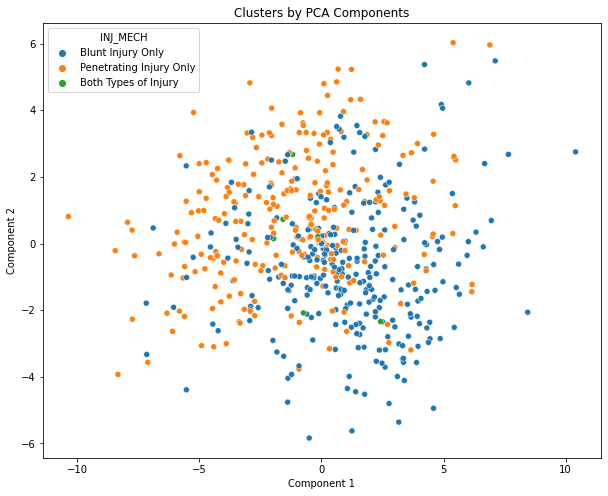

In [7]:
# Plot data by PCA components
x_axis = df_pca_kmeans['Component 1']
y_axis = df_pca_kmeans['Component 2']
plt.figure(figsize=(10, 8))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_pca_kmeans['INJ_MECH'])
plt.title("Clusters by PCA Components")
plt.show()

Permanova, LDA, Shannon Index, 